In [ ]:
import pandas as pd
import matplotlib.pyplot as pt
import numpy as np
import math
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
crypto = 'ETH'
against = 'INR'

data = yf.download(crypto+'-'+against)
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-11,19455.863281,20815.558594,19430.189453,20504.613281,20504.613281,54884332639
2017-11-12,20505.201172,20796.009766,19451.107422,20063.285156,20063.285156,105134352629
2017-11-13,20005.748047,21399.521484,20005.748047,20722.728516,20722.728516,68170861653
2017-11-14,20725.802734,22287.546875,20725.802734,22081.068359,22081.068359,69957072000
2017-11-15,22102.845703,22277.746094,21523.595703,21754.876953,21754.876953,47161182116


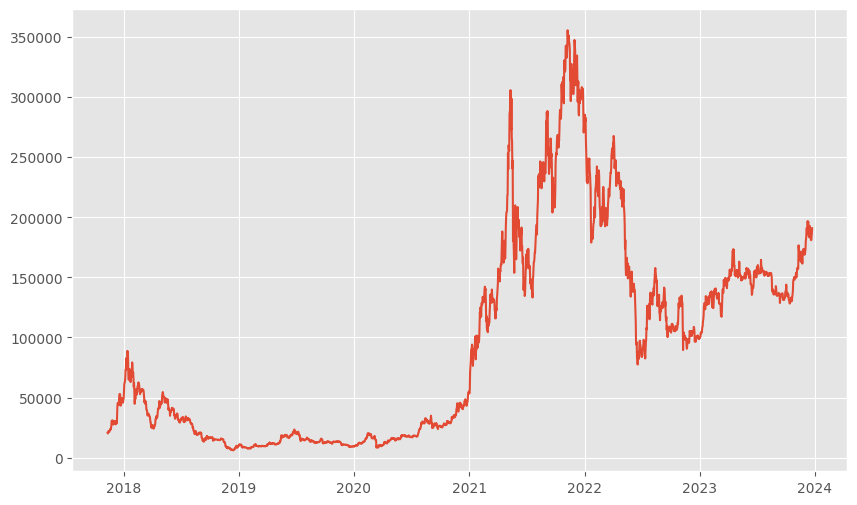

In [ ]:
pt.style.use('ggplot')
pt.figure(figsize=(10,6))
pt.plot(data.index,data['Close'])
pt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [ ]:
pred_days = 60
future_day = 30
xtrain,ytrain = [], []

for x in range(pred_days, len(scaled)-future_day):
  xtrain.append(scaled[x-pred_days:x,0])
  ytrain.append(scaled[x+future_day,0])

xtrain,ytrain = np.array(xtrain), np.array(ytrain)
x_train = np.reshape(xtrain, (xtrain.shape[0], xtrain.shape[1], 1))

In [ ]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xtrain,ytrain, epochs=25,batch_size=32)

Epoch 1/25
67/67 [==============================] - 10s 66ms/step - loss: 0.0153
Epoch 2/25
67/67 [==============================] - 6s 83ms/step - loss: 0.0104
Epoch 3/25
67/67 [==============================] - 5s 72ms/step - loss: 0.0102
Epoch 4/25
67/67 [==============================] - 4s 67ms/step - loss: 0.0094
Epoch 5/25
67/67 [==============================] - 6s 89ms/step - loss: 0.0092
Epoch 6/25
67/67 [==============================] - 4s 67ms/step - loss: 0.0090
Epoch 7/25
67/67 [==============================] - 4s 66ms/step - loss: 0.0092
Epoch 8/25
67/67 [==============================] - 6s 90ms/step - loss: 0.0088
Epoch 9/25
67/67 [==============================] - 4s 66ms/step - loss: 0.0092
Epoch 10/25
67/67 [==============================] - 5s 68ms/step - loss: 0.0086
Epoch 11/25
67/67 [==============================] - 7s 99ms/step - loss: 0.0085
Epoch 12/25
67/67 [==============================] - 5s 70ms/step - loss: 0.0088
Epoch 13/25
67/67 [=================

In [ ]:
test=yf.download(crypto+'-'+against, start=pd.to_datetime('2022-01-01'))
actual_price=test['Close'].values

total_dataset = pd.concat((data['Close'], test['Close']), axis=0)

model_input = total_dataset[len(total_dataset)-len(test)-pred_days:].values
model_input = model_input.reshape(-1,1)
model_input = scaler.fit_transform(model_input)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
xtest=[]

for x in range(pred_days, len(model_input)):
  xtest.append(model_input[x-pred_days:x,0])

xtest=np.array(xtest)
xtest=np.reshape(xtest,(xtest.shape[0], xtest.shape[1], 1))

pred=model.predict(xtest)
pred=scaler.inverse_transform(pred)

23/23 [==============================] - 2s 23ms/step


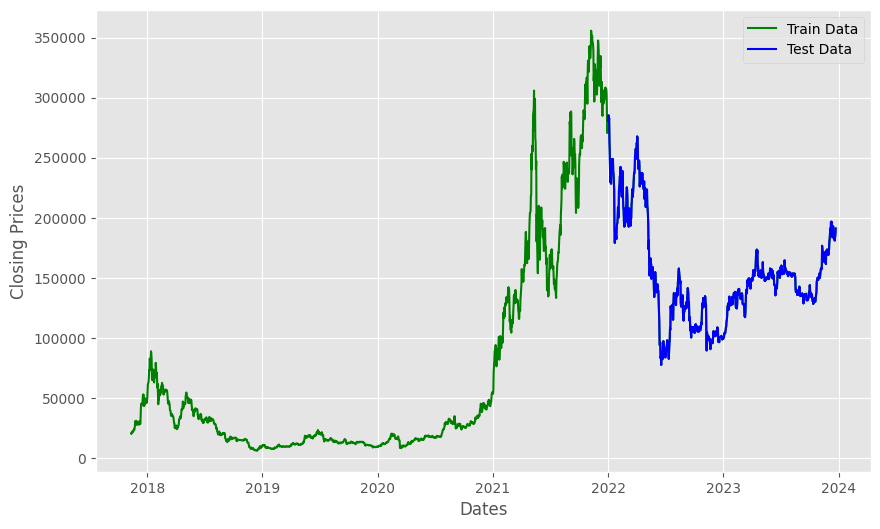

In [ ]:
pt.figure(figsize=(10,6))
pt.grid(True)

pt.xlabel('Dates')
pt.ylabel('Closing Prices')
pt.plot(data.index, data['Close'],c='g',label='Train Data')
pt.plot(test.index, test['Close'],c='b',label='Test Data')
pt.legend()
pt.show()

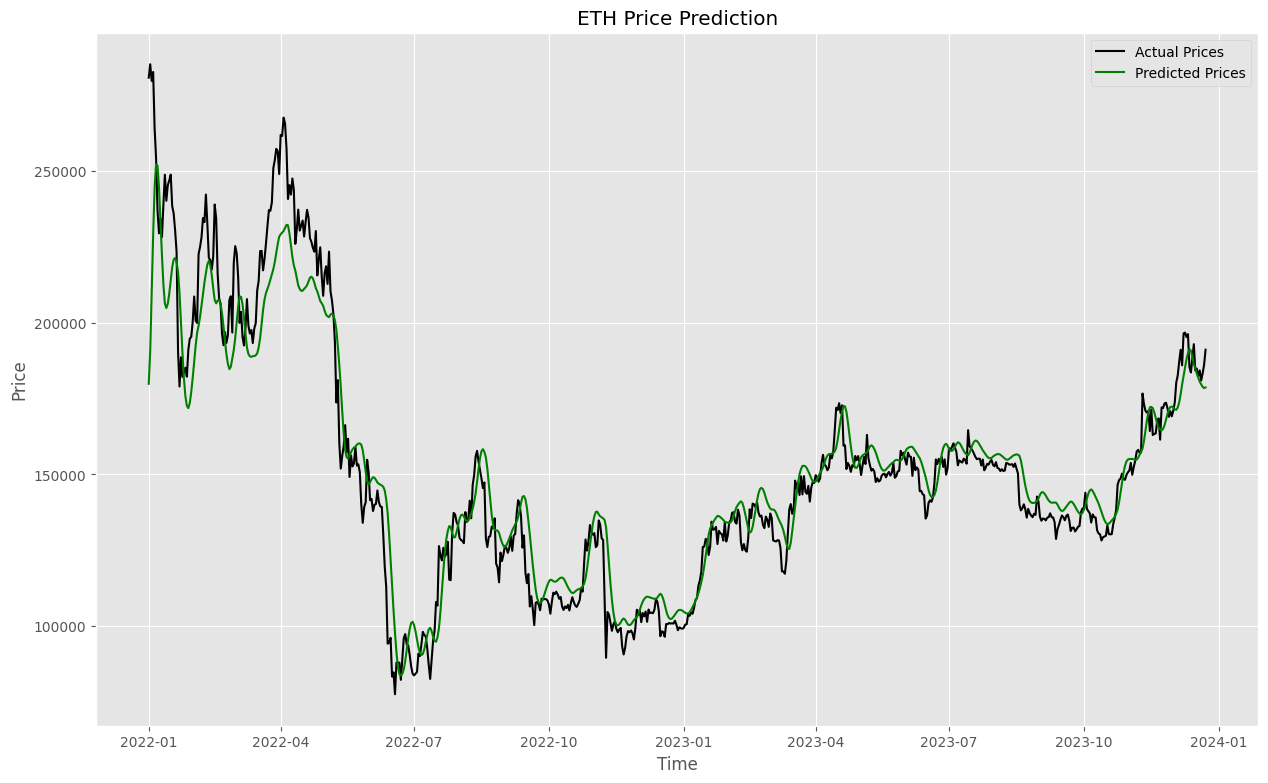

In [ ]:
pt.figure(figsize=(15, 9))
pt.grid(True)

pt.plot(test.index,actual_price, color='k', label='Actual Prices')
pt.plot(test.index,pred, color='g', label='Predicted Prices')
pt.title(crypto+' Price Prediction')
pt.xlabel('Time')
pt.ylabel('Price')
pt.legend()
pt.show()

[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 0s 58ms/step
(31,)
(31,)


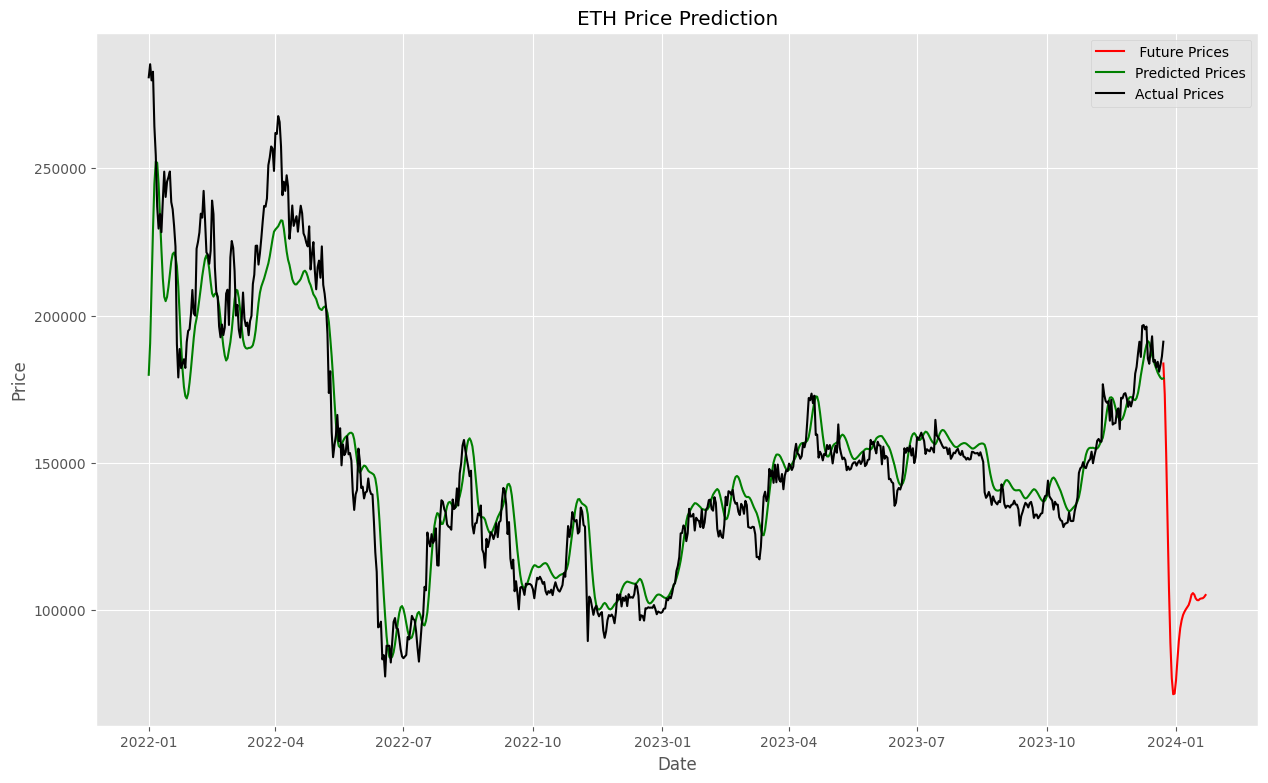

In [ ]:
# Define the future date range for prediction
future_start_date = '2023-12-23'  # Set the start date for future prediction
future_end_date = '2024-1-22'  # Set the end date for future prediction

future_data = yf.download(crypto + '-' + against, start=pd.to_datetime('2021-01-01'), end=pd.to_datetime(future_start_date))

total_dataset = pd.concat((data['Close'], test['Close'], future_data['Close']), axis=0)

future_model_input = total_dataset[len(total_dataset) - len(future_data) - pred_days:].values
future_model_input = future_model_input.reshape(-1, 1)
future_model_input = scaler.fit_transform(future_model_input)

# Prepare the input sequences for the model
future_xtest = []
for x in range(len(future_model_input[-31:])):
    future_xtest.append(future_model_input[x:x + pred_days, 0])

future_xtest = np.array(future_xtest)
future_xtest = np.reshape(future_xtest, (future_xtest.shape[0], future_xtest.shape[1], 1))

future_pred = model.predict(future_xtest)
future_pred = scaler.inverse_transform(future_pred)
future_pred = future_pred.flatten()

future_dates = pd.to_datetime(pd.date_range(start=future_start_date, end=future_end_date))

print(future_dates.shape)
print(future_pred.shape)
future_price_data = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_pred})

pt.figure(figsize=(15, 9))
pt.grid(True)

pt.plot(future_price_data['Date'], future_price_data['Predicted Price'], color='r', label=' Future Prices')
pt.plot(test.index,pred, color='g', label='Predicted Prices')
pt.plot(test.index,actual_price, color='k', label='Actual Prices')
pt.title(crypto + ' Price Prediction')
pt.xlabel('Date')
pt.ylabel('Price')
pt.legend()
pt.show()


In [ ]:
future_price_data.head(20)

,Date,Predicted Price
0,2023-12-23,183728.390625
1,2023-12-24,173260.390625
2,2023-12-25,153306.312500
3,2023-12-26,129734.078125
4,2023-12-27,107199.609375
5,2023-12-28,88890.664062
6,2023-12-29,76856.312500
7,2023-12-30,71442.398438
8,2023-12-31,71653.601562
9,2024-01-01,76162.289062
